# Read data

In [39]:
import pandas as pd
import datetime

activity_cols = {
    "Datum": "date",
    "Ø Pace": "pace_average",
    "Kalorien": "calories",
    "Zeit": "time",
    "Ø Herzfrequenz": "heart_rate_average",
    "Ø Atemfrequenz": "respiration_rate_average",
}
df_activities = pd.read_csv(
    "data/raw/all_activities.csv",
    usecols=list(activity_cols.keys())
)
df_activities.rename(columns=activity_cols, inplace=True)

sleep_cols = {
    "Sleep Score 7 Tage": "date",
    "Score": "score",
    "Dauer": "duration",
    "Schlafenszeit": "bedtime",
    "Ruheherzfrequenz": "resting_heart_rate",
    "Atmung": "respiration_rate",
    "HFV-Status": "hrv_status",
}
df_sleep = pd.read_csv(
    "data/raw/sleep.csv",
    usecols=list(sleep_cols.keys())
)
df_sleep.rename(columns=sleep_cols, inplace=True)


In [40]:
df_activities.head()

date calories      time heart_rate_average pace_average  \
0  2025-09-21 09:53:57    2,817  04:35:15                148         6:27   
1  2025-09-20 15:18:50      246  00:20:13                144         5:26   
2  2025-09-19 12:31:00      210  00:30:18                116         25.4   
3  2025-09-15 11:16:13      350  00:30:39                133         5:28   
4  2025-09-13 10:51:36      549  00:44:56                144         4:59   

  respiration_rate_average  
0                       30  
1                       30  
2                       --  
3                       26  
4                       32

In [41]:
df_sleep.head()

date score resting_heart_rate respiration_rate hrv_status  duration  \
0  2025-09-30    77                 44            11.38         83  6h 47min   
1  2025-09-29    73                 46               12         84   9h 6min   
2  2025-09-28    34                 47            14.96         84  6h 34min   
3  2025-09-27    93                 41            11.13         92  8h 32min   
4  2025-09-26    97                 42            11.15         90  7h 50min   

    bedtime  
0  11:22 PM  
1  10:52 PM  
2  12:34 AM  
3  10:39 PM  
4  10:07 PM

# Clean data/time features

In [42]:

def pace_to_seconds(pace_str):
    try:
        if isinstance(pace_str, str) and ":" in pace_str:
            parts = pace_str.split(":")
            if len(parts) == 2:
                minutes, seconds = int(parts[0]), int(parts[1])
                return minutes * 60 + seconds
            elif len(parts) == 3:  # If format is HH:MM:SS
                hours, minutes, seconds = int(
                    parts[0]), int(parts[1]), int(parts[2])
                return hours * 3600 + minutes * 60 + seconds
        return float(pace_str)
    except Exception:
        return 0


# activities
date = pd.to_datetime(df_activities["date"], errors="coerce")
df_activities["date"] = date.dt.date
df_activities['date'] = pd.to_datetime(df_activities['date'], errors='coerce')
df_activities["time"] = date.dt.time
df_activities["time_seconds"] = df_activities["time"].apply(
    lambda t: t.hour * 3600 + t.minute * 60 +
    t.second if hasattr(t, "hour") else 0
)

df_activities["pace_average"] = df_activities["pace_average"].apply(
    pace_to_seconds)

df_activities.head()

date calories      time heart_rate_average  pace_average  \
0 2025-09-21    2,817  09:53:57                148         387.0   
1 2025-09-20      246  15:18:50                144         326.0   
2 2025-09-19      210  12:31:00                116          25.4   
3 2025-09-15      350  11:16:13                133         328.0   
4 2025-09-13      549  10:51:36                144         299.0   

  respiration_rate_average  time_seconds  
0                       30         35637  
1                       30         55130  
2                       --         45060  
3                       26         40573  
4                       32         39096

In [43]:
df_activities.dtypes

date                        datetime64[ns]
calories                            object
time                                object
heart_rate_average                  object
pace_average                       float64
respiration_rate_average            object
time_seconds                         int64
dtype: object

In [44]:


numeric_columns = [
    "calories",
    "heart_rate_average",
    "respiration_rate_average",
    "pace_average",
    "time_seconds",
]

for col in numeric_columns:
    if df_activities[col].dtype == "object":
        df_activities[col] = pd.to_numeric(df_activities[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_activities[col] = pd.to_numeric(df_activities[col], errors='coerce')

df_activities.head()

date  calories      time  heart_rate_average  pace_average  \
0 2025-09-21      2817  09:53:57                 148         387.0   
1 2025-09-20       246  15:18:50                 144         326.0   
2 2025-09-19       210  12:31:00                 116          25.4   
3 2025-09-15       350  11:16:13                 133         328.0   
4 2025-09-13       549  10:51:36                 144         299.0   

   respiration_rate_average  time_seconds  
0                        30         35637  
1                        30         55130  
2                         0         45060  
3                        26         40573  
4                        32         39096

In [45]:
df_activities.dtypes

date                        datetime64[ns]
calories                             int64
time                                object
heart_rate_average                   int64
pace_average                       float64
respiration_rate_average             int64
time_seconds                         int64
dtype: object

In [46]:
def bedtime_to_seconds(bedtime_str):
    try:
        t = pd.to_datetime(bedtime_str, format="%I:%M %p", errors="coerce")
        if pd.isnull(t):
            return 0
        return t.hour * 3600 + t.minute * 60 + t.second
    except Exception:
        return 0

df_sleep["bedtime_seconds"] = df_sleep["bedtime"].apply(bedtime_to_seconds)

df_sleep["date"] = pd.to_datetime(df_sleep["date"], errors="coerce")

df_sleep["duration"] = pd.to_timedelta(df_sleep["duration"], errors="coerce")
df_sleep["duration_seconds"] = (
    df_sleep["duration"].dt.total_seconds().fillna(0).astype(int)
)

In [47]:
numeric_columns = [
    "score",
    "duration_seconds",
    "bedtime_seconds",
    "resting_heart_rate",
    "respiration_rate",
    "hrv_status"
]

for col in numeric_columns:
    if df_sleep[col].dtype == "object":
        df_sleep[col] = pd.to_numeric(df_sleep[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_sleep[col] = pd.to_numeric(df_sleep[col], errors='coerce')


df_sleep.head()

date  score  resting_heart_rate  respiration_rate  hrv_status  \
0 2025-09-30     77                  44             11.38          83   
1 2025-09-29     73                  46             12.00          84   
2 2025-09-28     34                  47             14.96          84   
3 2025-09-27     93                  41             11.13          92   
4 2025-09-26     97                  42             11.15          90   

         duration   bedtime  bedtime_seconds  duration_seconds  
0 0 days 06:47:00  11:22 PM            84120             24420  
1 0 days 09:06:00  10:52 PM            82320             32760  
2 0 days 06:34:00  12:34 AM             2040             23640  
3 0 days 08:32:00  10:39 PM            81540             30720  
4 0 days 07:50:00  10:07 PM            79620             28200

# Corelation Matrix sleep after training

In [76]:
df_latest_activity = df_activities.sort_values('time').groupby('date', as_index=False).last()

df_combined = pd.merge(df_latest_activity, df_sleep, on='date', how='right')
df_combined.count()

date                        365
calories                    251
time                        251
heart_rate_average          251
pace_average                251
respiration_rate_average    251
time_seconds                251
score                       365
resting_heart_rate          365
respiration_rate            365
hrv_status                  365
duration                    364
bedtime                     365
bedtime_seconds             365
duration_seconds            365
dtype: int64

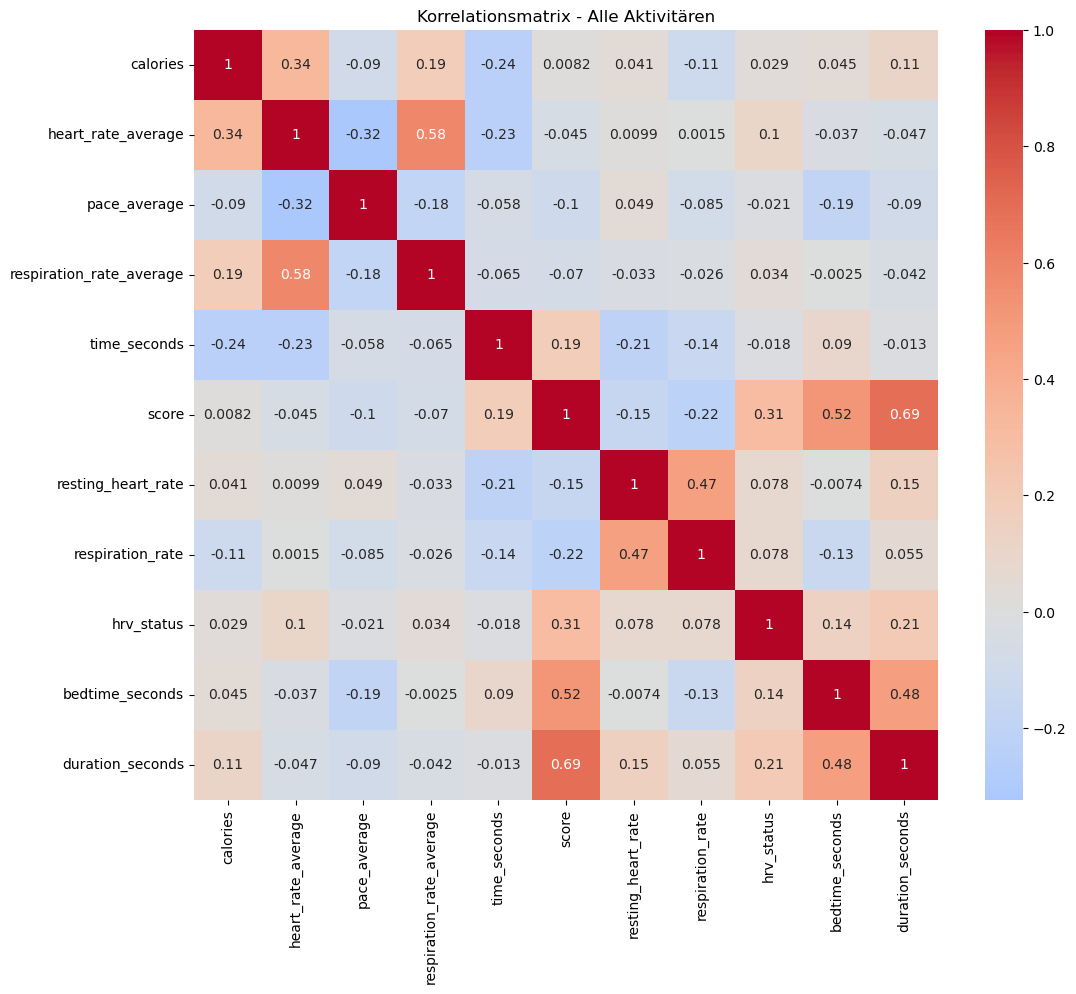

In [77]:
correlation_matrix = df_combined.corr(numeric_only=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix - Alle Aktivitären")
plt.show()

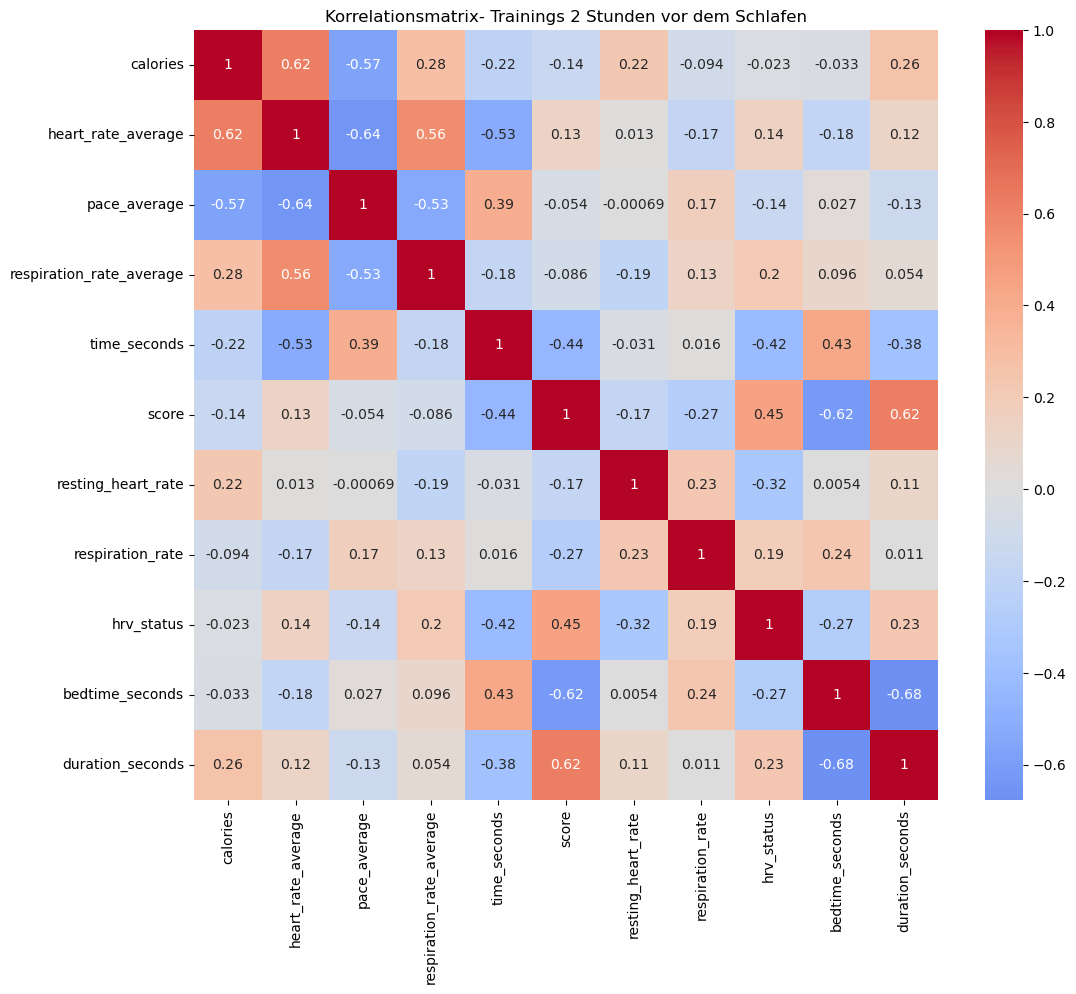

In [78]:
if "time_seconds" in df_combined.columns and "bedtime_seconds" in df_combined.columns:
    df_combined["time_diff_activity_to_sleep_time_seconds"] = (
        df_combined["bedtime_seconds"] - df_combined["time_seconds"] + df_combined["duration_seconds"]
    )

filtered = df_combined[df_combined["time_diff_activity_to_sleep_time_seconds"] < 2 * 60 * 60]
filtered = filtered.drop(columns=["time_diff_activity_to_sleep_time_seconds"])

correlation_matrix = filtered.corr(numeric_only=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix- Trainings 2 Stunden vor dem Schlafen")
plt.show()

/var/folders/cp/r09cdjsd4hzc7p8vtlkxw48h0000gn/T/ipykernel_9401/1428926002.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


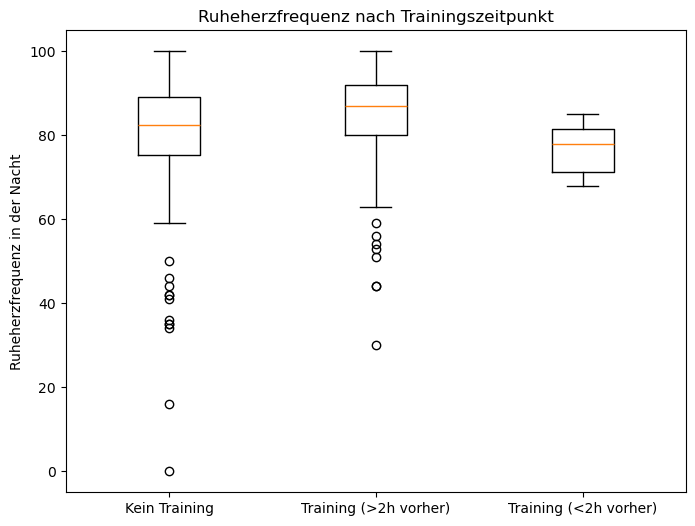

Kein Training: 114
Training (>2h vorher): 241
Training (<2h vorher): 10
Total days: 365


In [ ]:
import matplotlib.pyplot as plt
df_combined['training_this_day'] = df_combined['calories'].notna()
df_combined['training_2h_before_sleep'] = (
    (df_combined['training_this_day']) &
    (df_combined['time_diff_activity_to_sleep_time_seconds'].abs() < 3 * 60 * 60)
)

# 3. Gruppiere die Daten
group_no_training = df_combined[~df_combined['training_this_day']]['score']
group_training_2h_before_sleep = df_combined[df_combined['training_2h_before_sleep']]['score']
group_training_more_than_2h = df_combined[
    df_combined['training_this_day'] & ~df_combined['training_2h_before_sleep']
]['score']


# 4. Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(
    [group_no_training.dropna(), group_training_more_than_2h.dropna(), group_training_2h_before_sleep.dropna()],
    labels=['Kein Training', 'Training (>2h vorher)', 'Training (<2h vorher)']
)
plt.ylabel('Ruheherzfrequenz in der Nacht')
plt.title('Ruheherzfrequenz nach Trainingszeitpunkt')
plt.show()

print("Kein Training: 1 ", len(group_no_training.dropna()))
print("Training (>2h vorher): 1 ", len(group_training_more_than_2h.dropna()))
print("Training (<2h vorher): 1 ", len(group_training_2h_before_sleep.dropna()))

total_days = (
    len(group_no_training.dropna()) +
    len(group_training_more_than_2h.dropna()) +
    len(group_training_2h_before_sleep.dropna())
)
print("Total days:", total_days)  # Should be 365
